<a href="https://colab.research.google.com/github/ArjunNarendra/455finalproject/blob/main/Noisy_Captcha_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Breaking CAPTCHAs

Our final project will involve solving CAPTCHAs, which are images with sequences of letters and numbers used to "verify" that a user is a human.

##Step 1: Neural Network Modeling

Since CAPTCHAs use uppercase, lowercase, and digits, we will be using the EMNIST dataset to create a classifier. After we train it, we can use the pre-trained weights. That means that this section of code should only be run once to train the classifier.

In [ ]:
import torch
import torchvision

def get_emnist_data():
  # Need to perform a rotate and flip to properly orient the images
  trainset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=True, download=True,
                                        transform=torchvision.transforms.Compose([
                                            lambda img: torchvision.transforms.functional.rotate(img, -90),
                                            lambda img: torchvision.transforms.functional.hflip(img),
                                            torchvision.transforms.ToTensor()
                                        ]))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)

  testset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          lambda img: torchvision.transforms.functional.rotate(img, -90),
                                          lambda img: torchvision.transforms.functional.hflip(img),
                                          torchvision.transforms.ToTensor()
                                      ]))
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
  # 0-9 are for digits, 10-35 are for uppercase letters, 36-61 are for lowercase letters
  classes = []
  for i in range(0, 10):
    classes.append(i)
  for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    classes.append(letter)
  for letter in "abcdefghijklmnopqrstuvwxyz":
    classes.append(letter)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

In [ ]:
# Get EMNIST data
data = get_emnist_data()

In [ ]:
# Print out details about the training data
print(data['train'].__dict__)

In [ ]:
# Print out details about the testing data
print(data['test'].__dict__)

In [ ]:
# Get images and labels for one batch of the training data
dataiter = iter(data['train'])
images, labels = next(dataiter)
print(images.size())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Show first batch of images
imshow(torchvision.utils.make_grid(images))
# Print labels for first 8 digits
print("Labels:" + ' '.join('%9s' % data['classes'][labels[j]] for j in range(8)))

print(images.size())
flat = torch.flatten(images, 1)
print(flat.size())

In [ ]:
import torch

# Try to switch to the CPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
import torch.optim as optim

def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0005, verbose=1):
  net.to(device)
  losses = []
  # We are using CrossEntropy loss and Stochastic Gradient Descent 
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
  for epoch in range(epochs):
    sum_loss = 0.0
    for i, batch in enumerate(dataloader, 0):
      # Get the inputs and associated labels for this particular batch of data
      inputs, labels = batch[0].to(device), batch[1].to(device)
      # Zero the parameter gradients
      optimizer.zero_grad()
      # Forward propogate, backward propogate, and update weights
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()  
      optimizer.step()
      # Print loss information every 100 batches
      losses.append(loss.item())
      sum_loss += loss.item()
      if i % 100 == 99:
        if verbose:
          print('[%d, %5d] loss: %.3f' %
            (epoch + 1, i + 1, sum_loss / 100))
        sum_loss = 0.0
  return losses

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Convolutional neural network with two convolutional layers
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # Input 28x28x1 image
    # 16 filters
    # 3x3 filter size (they also have 3 channels)
    # stride 2 (downsampling by factor of 2)
    # Output image: 14x14x16
    self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)

    # Input 14x14x16 image
    # 32 filters
    # 3x3x16 filter size (they also have 16 channels)
    # stride 2 (downsampling by factor of 2)
    # Output image: 7x7x32
    self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

    # Fully connected linear layer
    self.fc1 = nn.Linear(1568, 62)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

In [ ]:
# Use simulated annealing for training ConvNet
anneal_net = ConvNet()

anneal_losses =  train(anneal_net, data['train'], epochs=2, lr=.1)
anneal_losses += train(anneal_net, data['train'], epochs=2, lr=.01)
anneal_losses += train(anneal_net, data['train'], epochs=2, lr=.001)

plt.plot(anneal_losses)

In [ ]:
from google.colab import files

# Save the model weights into a file, then download that file
torch.save(anneal_net.state_dict(), 'model_state.pth')
files.download('model_state.pth')

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader: 
      # Get images and labels for the current batch
      images, labels = batch[0].to(device), batch[1].to(device)
      # Get predicted labels from our network
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      # Tally up the number of correct predictions that our network made
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
print("AnnealNet train accuracy: %f" % accuracy(anneal_net, data['train']))

In [ ]:
print("AnnealNet test accuracy: %f" % accuracy(anneal_net, data['test']))


## Step 2: Load images

We load images of CAPTCHAs from a Kaggle dataset.

In [ ]:
# NOTE: First, must upload kaggle.json with credentials
# Install the kaggle library
! pip install kaggle
# Make a directory named .kaggle
! mkdir ~/.kaggle
# Copy the kaggle.json into this new directory
! cp kaggle.json ~/.kaggle/
# Allocate the required permissions for this file
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download the noisy CAPTCHA dataset
! kaggle datasets download alizahidraja/captcha-data

  0% 0.00/8.72M [00:00<?, ?B/s]
100% 8.72M/8.72M [00:00<00:00, 92.7MB/s]


In [ ]:
# Unzip the file
! unzip captcha-data.zip

In [ ]:
import glob
import torchvision
import re
from PIL import Image
import numpy as np

# Dictionary for images. Key is the filename information. Value is the pixel data
# stored as a tensor.
imagesDict = {}

for im_path in glob.glob("data/*/*.png"):
  # Convert the image to one channel
  oneChannelImage = Image.open(im_path).convert("L")
  # Transform the image to a numpy array
  imageData = np.array(oneChannelImage, dtype=np.uint8)
  # Extract relevant file name information
  filename = re.search(r"[A-Za-z1-9]{5}", im_path).group()
  # Add the key-value mapping to dictionary
  imagesDict[filename] = imageData

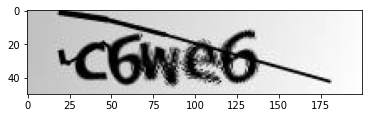

(50, 200)


In [ ]:
import matplotlib.pyplot as plt

# Get all the tags of the images in this dataset
imagesTags = list(imagesDict.keys())
# Get the tag corresponding to the first image
firstImageTag = imagesTags[0]
# Get the image data corresponding to the tag
imageData = imagesDict.get(firstImageTag)

# Show this image with dimensions 24 x 72
plt.gray()
plt.imshow(imageData)
plt.show()

# Print out its dimensions
print(imageData.shape)

## Step 3: Denoising and Character Segmentation

We denoise a CAPTCHA, find bounding boxes around each character in the CAPTCHA, extract the individual characters, and normalize them.

In [ ]:
def flipColor(character):
  for i in range(character.shape[0]):
    for j in range(character.shape[1]):
      # Let's say that anything at or above 150 will go to 0
      if character[i, j] > 150:
        character[i, j] = 0
      else:
        character[i, j] = 255
  return character

In [ ]:
import scipy
import cv2

# Given a purely black-and-white image, attempt
# to remove line, dot, and fuzziness noise 
def denoise_captcha(img):
  eroded = img
  eroded = eroded.astype('uint8')

  # perform a 2x2 erosion to chop up larger line noise
  erode_kernel = np.ones((2, 2), np.uint8)
  eroded = cv2.erode(eroded, erode_kernel, iterations=1)

  # use both vertical and horizontal median filters
  # to eliminate the chopped-up line noise
  med_1 = scipy.ndimage.median_filter(eroded, (5, 2))
  med_2 = scipy.ndimage.median_filter(med_1, (1, 3))

  # dilate to buff up the legitimate characters' lines, which have
  # been weakened by the above operations
  dilate_kernel = np.ones((3, 3), np.uint8)
  dilated = cv2.dilate(med_2, dilate_kernel, iterations=1)

  # in case the dilation also made noisy dots stronger,
  # perform another median as a final step to weaken
  # this noise
  denoised = scipy.ndimage.median_filter(dilated, (2, 2))

  return denoised

In [ ]:
def segment_noise(im):
  # since this image is larger, using a bigger min area will lead to 
  # better filtering
  MIN_CHAR_AREA = 200

  seg_chars = []

  # change this if there are more than 5 characters per noisy
  # captcha
  TOT_CHARS = 5

  to_segment = np.copy(im)
  blurred = cv2.blur(to_segment, (5,5), 0)
  img_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

  contours, hierarchy = cv2.findContours(img_thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

  # TODO: uncomment and run this loop (and the following 
  # plt lines outside this loop) to generate some cool pics for 
  # the writeup
  # for contour in contours:
  #     if cv2.contourArea(contour) > MIN_CHAR_AREA:
  #         [X, Y, W, H] = cv2.boundingRect(contour)
  #         cv2.rectangle(to_segment, (X, Y), (X + W, Y + H), (0,255, 0), 1)
  
  # plt.imshow(to_segment)
  # plt.show()

  # cv2.boundingRect returns X, Y, and width and height of the bounding
  # box. Use the box's X coordinate to sort the contours from left to right,
  # which will make it easier to enumerate through individual characters
  contours = sorted(contours, key=lambda contour: cv2.boundingRect(contour)[0])
  # first, get the effective area of all the contours
  tot_contours_area = 0.0
  tot_width = 0.0
  for contour in contours:
    # get based on width
    w = cv2.boundingRect(contour)[2]
    c_area = cv2.contourArea(contour)
    if c_area >= MIN_CHAR_AREA:
      tot_contours_area += c_area
      tot_width += w
  
  # using this contours area, we can roughly approximate how to split
  # contours that encompass multiple characters 

  for contour in contours:
    c_area = cv2.contourArea(contour)
    if c_area >= MIN_CHAR_AREA:
      x, y, w, h = cv2.boundingRect(contour)

      multi_char = im[y:y+h, x:x+w]

      # to split, first figure out how many characters are in the
      # contour. Take the fraction of the total effective contour
      # area encompassed by this contour (we can also do it based on width
      # of the contours)

      frac_area = c_area / tot_contours_area
      frac_width = w / tot_width
      # may need to adjust this rounding for boundary cases
      num_chars = round(TOT_CHARS * frac_area)
      num_chars_w = round(TOT_CHARS * frac_width)

      if num_chars_w < 1:
        continue

      # Major assumption: all characters are roughly the same width.
      # This might be a dangerous assumption to make, but we will have
      # to do with it for now...
      # char_w = w // num_chars
      char_w = w // num_chars_w

      chars = []

      for i in range(num_chars):
        char_start = i * char_w
        chars.append(multi_char[:, char_start:char_start+char_w])

      for char in chars:
        # EMNIST uses square images
        char_w = char.shape[1]
        char_h = char.shape[0]
        square = max(char.shape[0], char.shape[1])

        square_char = np.zeros((square, square), dtype=np.uint8)
        square_char[...] = 255

        # center the image
        x_off = (square - char_w) // 2
        y_off = (square - char_h) // 2

        square_char[y_off:y_off+char_h, x_off:x_off+char_w] = char

        adj_char = cv2.resize(square_char, (28, 28), interpolation=cv2.INTER_AREA)

        seg_chars.append(adj_char)

  return seg_chars

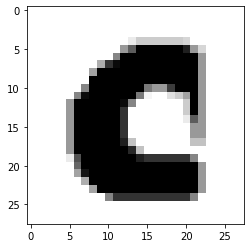

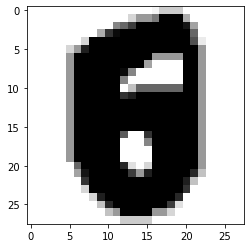

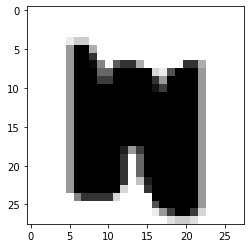

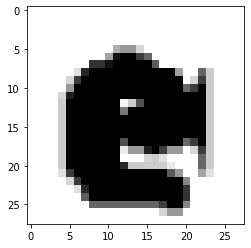

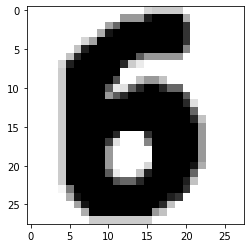

In [ ]:
imageData = flipColor(imageData)
imageDenoised = denoise_captcha(imageData)
imageDenoised = flipColor(imageDenoised)
characters = segment_noise(imageDenoised)
for character in characters:
  plt.imshow(character)
  plt.show()

## Step 4: CAPTCHA Processing

Once we have trained our neural network model on the EMNIST dataset, we can proceed to test our model on a CAPTCHA. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Convolutional neural network with two convolutional layers
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    # Input 28x28x1 image
    # 16 filters
    # 3x3 filter size (they also have 3 channels)
    # stride 2 (downsampling by factor of 2)
    # Output image: 14x14x16
    self.conv1 = nn.Conv2d(1, 16, 3, stride=2, padding=1)

    # Input 14x14x16 image
    # 32 filters
    # 3x3x16 filter size (they also have 16 channels)
    # stride 2 (downsampling by factor of 2)
    # Output image: 7x7x32
    self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)

    # Fully connected linear layer
    self.fc1 = nn.Linear(1568, 62)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

In [ ]:
import torch

# Try to switch to the CPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch

# Reload weights from previously trained model
# NOTE: Must upload file that contains model's pre-trained weights
anneal_net = ConvNet()
anneal_net.to(device)
state_dict = torch.load('model_state.pth')
anneal_net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def accuracy(net, dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for batch in dataloader: 
      # Get images and labels for the current batch
      images, labels = batch[0].to(device), batch[1].to(device)
      # Get predicted labels from our network
      outputs = net(images)
      _, predicted = torch.max(outputs.data, 1)
      # Tally up the number of correct predictions that our network made
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  return correct/total

In [ ]:
import torch
import torchvision

def get_emnist_data():
  # Need to perform a rotate and flip to properly orient the images
  trainset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=True, download=True,
                                        transform=torchvision.transforms.Compose([
                                            lambda img: torchvision.transforms.functional.rotate(img, -90),
                                            lambda img: torchvision.transforms.functional.hflip(img),
                                            torchvision.transforms.ToTensor()
                                        ]))
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=8)

  testset = torchvision.datasets.EMNIST(root='./data', split='byclass', train=False, download=True,
                                      transform=torchvision.transforms.Compose([
                                          lambda img: torchvision.transforms.functional.rotate(img, -90),
                                          lambda img: torchvision.transforms.functional.hflip(img),
                                          torchvision.transforms.ToTensor()
                                      ]))
  testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=8)
  # 0-9 are for digits, 10-35 are for uppercase letters, 36-61 are for lowercase letters
  classes = []
  for i in range(0, 10):
    classes.append(i)
  for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    classes.append(letter)
  for letter in "abcdefghijklmnopqrstuvwxyz":
    classes.append(letter)
  return {'train': trainloader, 'test': testloader, 'classes': classes}

In [ ]:
data = get_emnist_data()

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Ensure that the pre-trained model gives reasonable accuracy on the EMNIST dataset
print("AnnealNet train accuracy: %f" % accuracy(anneal_net, data['train']))
print("AnnealNet test accuracy: %f" % accuracy(anneal_net, data['test']))

AnnealNet train accuracy: 0.846052
AnnealNet test accuracy: 0.841020


In [ ]:
def createIndexToCharacterMap():
  indexToCharacter = []
  for i in range(0, 10):
    indexToCharacter.append(i)
  for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ":
    indexToCharacter.append(letter)
  for letter in "abcdefghijklmnopqrstuvwxyz":
    indexToCharacter.append(letter)
  return indexToCharacter

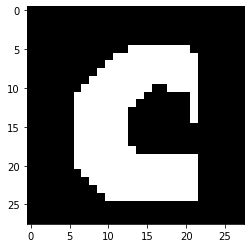

Prediction: c


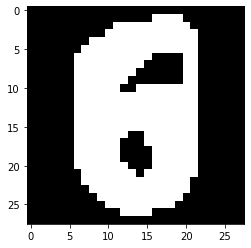

Prediction: B


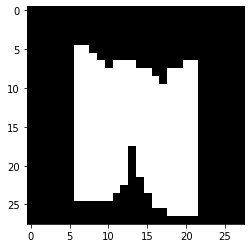

Prediction: N


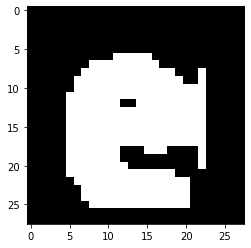

Prediction: e


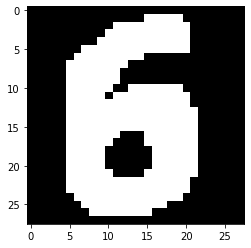

Prediction: G


In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

indexToCharacterMap = createIndexToCharacterMap()
transform = transforms.Compose([transforms.ToTensor()])

# Feed each character of the CAPTCHA into the neural network and make a prediction
for character in characters:
  # Flip color schema of character to match that of the EMNIST dataset
  character = flipColor(character)
  plt.imshow(character)
  plt.show()
  # Transform ndarray to tensor before feeding into character into neural network
  character = transform(character)
  with torch.no_grad():
    output = anneal_net(character.unsqueeze(0).to(device))
    modelPrediction = output.argmax(dim=1)
    print("Prediction: " + str(indexToCharacterMap[modelPrediction.item()]))


## Step 5: Putting it all Together

Let us see how well our model performs on all the CAPTCHA images in the dataset.

In [ ]:
from torchvision import transforms

def accuracy(net, imagesDict):
  # Initial set up
  numCorrectCAPTCHAs = 0
  numTotalCAPTCHAs = 0
  numCorrectCharacters = 0
  numTotalCharacters = 0
  numTotalFailedSegments = 0
  indexToCharacterMap = createIndexToCharacterMap()
  transform = transforms.Compose([transforms.ToTensor()]) 

  # Go through each CAPTCHA image in the dataset and calculate relevant statistics
  for imageTag in imagesDict:
    imageData = imagesDict.get(imageTag)
    # Denoise and segment image
    imageData = flipColor(imageData)
    imageDenoised = denoise_captcha(imageData)
    imageDenoised = flipColor(imageDenoised)
    characters = segment_noise(imageDenoised)
    numCorrectCharactersInCAPTCHA = 0
    currCharacter = 0
    # If we have accurately detected that there are five characters in the image,
    # then we should process it. Otherwise, we should ignore it.
    if (len(characters) == 5):
      for character in characters:
        character = flipColor(character)
        character = transform(character)
        with torch.no_grad():
          output = anneal_net(character.unsqueeze(0).to(device))
          modelPrediction = output.argmax(dim=1)
          prediction = str(indexToCharacterMap[modelPrediction.item()])
          if prediction == imageTag[currCharacter]:
            numCorrectCharactersInCAPTCHA = numCorrectCharactersInCAPTCHA + 1
          currCharacter = currCharacter + 1
      if numCorrectCharactersInCAPTCHA == 5:
        numCorrectCAPTCHAs = numCorrectCAPTCHAs + 1
      numCorrectCharacters = numCorrectCharacters + numCorrectCharactersInCAPTCHA
    else:
      numTotalFailedSegments += 1
    
    numTotalCAPTCHAs = numTotalCAPTCHAs + 1
    numTotalCharacters = numTotalCharacters + 5
    
  return [numCorrectCAPTCHAs / numTotalCAPTCHAs, numCorrectCharacters / numTotalCharacters, numTotalFailedSegments]

In [ ]:
accuracies = accuracy(anneal_net, imagesDict)
print("CAPTCHA accuracy: %f" % accuracies[0])
print("Character accuracy: %f" % accuracies[1])
print("Number of failed segmentations: %d" % accuracies[2])

CAPTCHA accuracy: 0.000000
Character accuracy: 0.150476
Number of failed segmentations: 14
